# P02 - Naive Bayes classifier for Fake News recognition

### Task of the project:

Fake news are defined by the New York Times as ”a made-up story with an intention to deceive”, with
the intent to confuse or deceive people. They are everywhere in our daily life, and come especially from
social media platforms and applications in the online world. Being able to distinguish fake contents form
real news is today one of the most serious challenges facing the news industry. Naive Bayes classifiers [1]
are powerful algorithms that are used for text data analysis and are connected to classification tasks of
text in multiple classes. The goal of the project is to implement a Multinomial Naive Bayes classifier in
R and test its performances in the classification of social media posts. The suggested data set is available
on Kaggle [2]. Possible suggested lables for classifying the text are the following:
- True - 5
- Not-Known - 4
- Mostly-True - 3
- Half-True - 2
- False - 1
- Barely-True - 0

The Kaggle dataset [2] consists of a training set wth 10,240 instances and a test set wth 1,267 instances.
- divide the dataset into a training, validation and testing set;
- tokenize each word in the data set (convert uppercase to lowercase) and split into tokens;
- clean the collection of words from stop words;
- perform token normalization: create equivalence classes so that similar tokens are mapped in the same class
- build the vocabulary and perform feature selection
- show the results

Apply the developed methods and technique to a new dataset [3] which is characterized by only two
labels: 

1 → unreliable and 0 → reliable.

Draw your conclusions on the results obtained on the two data sets.


[2] Fake News Content Detection, KAGGLE data set: https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv

[3] Fake News: build a system to identify unreliable news articles https://www.kaggle.com/competitions/fake-news/data?select=train.csv

In [2]:
library(tidyverse)
library(tm)
library(stopwords) #package for removing stopwords
library(SnowballC) #package for normalization
library(wordcloud) #wordcloud
library(readr)
library(dplyr)
library(ggplot2)
library(tokenizers) #package for tokenizing
library(caret)
library(repr)
options(repr.plot.width=10, repr.plot.height=10)

## Uploading and splitting the dataset

In [3]:
trval_data <-  read_csv('Project/train.csv', show_col_types = FALSE)
head(trval_data,5)

Labels,Text,Text_Tag
<dbl>,<chr>,<chr>
1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
2,The economic turnaround started at the end of my term.,"economy,jobs"


Firstly we would like to explore the occurancy of labels.

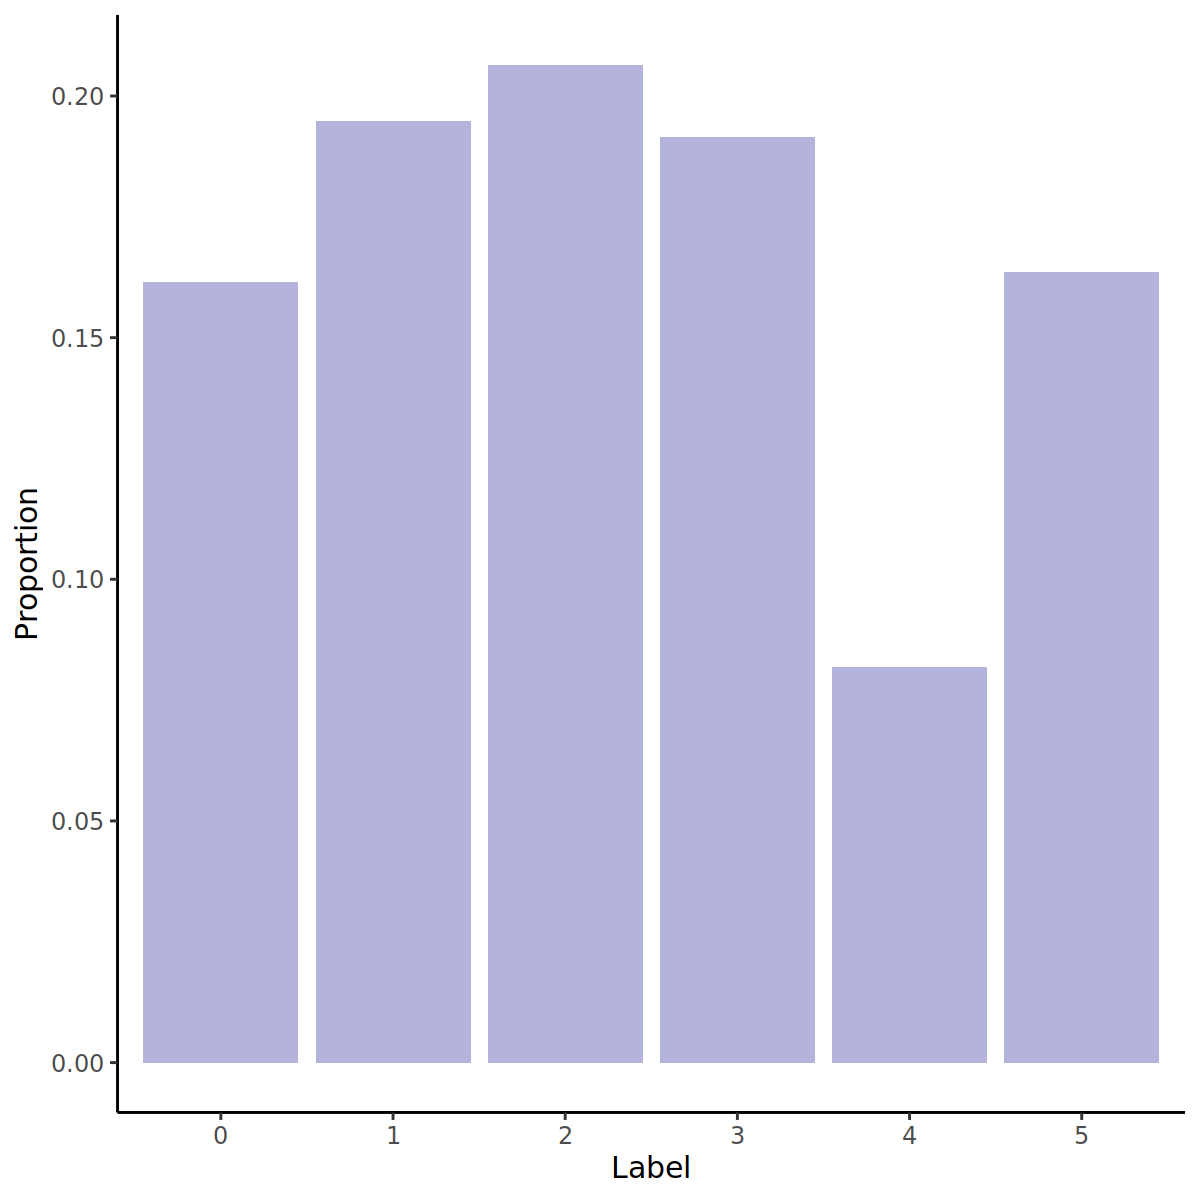

In [4]:
labels <- 0:5

n_occ <- sapply(labels, function(label) sum(trval_data$Labels == label))
df <- data.frame(Label = labels, Occurancy = n_occ)

label_proportions <- prop.table(table(trval_data$Labels))

df_plot <- data.frame(Label = names(label_proportions),
                      Proportion = label_proportions)

df_plot %>% ggplot(aes(x = Label, y = Proportion.Freq)) +
    geom_bar(stat = "identity", fill = "darkblue", alpha=0.3) +
    labs(x = "Label", y = "Proportion") +
    theme_classic(base_size=18) 

Secondly we split the first dataset into train and test sets.

In [5]:
sample <- sample(c(TRUE, FALSE), nrow(trval_data), replace=TRUE, prob=c(0.6,0.4))
train_data <- trval_data[sample, ]
test_data <- trval_data[!sample, ]
print(dim(train_data))
print(dim(test_data))

[1] 6181    3
[1] 4059    3


## DATA PREPARATION

- Stopword Removal
- Tokenization
- Token Normalization
- Building Vocabulary and Feature Selection

## Stopword and other non-useful information removal
Stop words are commonly occurring words that do not carry any significant meaning. For example, such words as "the", "is", "and" can be considered as stop words. We would like to remove these words in order to eliminate the noise and fasten the performance of the algorithm.

In this part we use the **tm** library in order to create the corpus object out of the provided data and remove the stop words.

In [6]:
text_cleaning <- function(data, print=FALSE){
    
    #turn off the warnings, because they are not useful here
    defaultW <- getOption("warn") 
    options(warn = -1) 

    document <- tolower(data) #transform to lowercase

    corpus <- Corpus(VectorSource(document))
    corpus <- tm_map(corpus, removeWords, stopwords("en")) #remove stop words
    corpus <- tm_map(corpus, removeWords, letters) #remove standalone letters, e.g. "m"
    corpus <- tm_map(corpus, removePunctuation) #remove punctuation
    corpus <- tm_map(corpus, removeNumbers) #remove numbers
    corpus <- tm_map(corpus, stripWhitespace) #remove excess white space
    
    if (print==TRUE){
        num_to_show <- sample(1:20,1)

        cleaned <- as.character(corpus[[num_to_show]])

        cat("--- Example of an original sentence: \n")
        cat(document[num_to_show], "\n \n")

        cat("--- Example of a cleaned sentence:\n")
        cat(cleaned)
        }
    
    options(warn = defaultW) #turn on the warnings back
    
    return(corpus)
}

Here we run the function for the training set just as an example in order to see the effect of cleaning.

In [7]:
cat('TRAIN DATA \n')
corpus_train <- text_cleaning(train_data$Text, print=TRUE)

TRAIN DATA 
--- Example of an original sentence: 
since 2000, nearly 12 million americans have slipped out of the middle class and into poverty. 
 
--- Example of a cleaned sentence:
since nearly million americans slipped middle class poverty

## Tokenization and token normalization

In order to further use available dataset as a training set for Naive Bayes Classifier we need to convert human-readable texts into so-called tokens. The simple tokenization is splitting the text into words. After doing this we also want to move to word-stem tokenization (token normalization). We are not interested in the different forms of the same word, so we consider just the stem of each word.

In [8]:
tokenization <- function(corpus, df_creation=FALSE){
    
    document <- as.character(corpus) #take only text from a corpus object

    document_cl <- tokenize_words(document)
    
    tokens <- unlist(document_cl)

    normed_tokens <- wordStem(tokens, language = "en")

    if (df_creation==TRUE){return(data.frame(normed_tokens))
    } else {return(normed_tokens)}
                           
}

Then we can combine the previous step with the current one into one big function.

In [9]:
preprocessing <- function(data, df_creation=FALSE){
    
    corpus <- text_cleaning(data)
    
    tokens = tokenization(corpus[[1]], df_creation)
    
    return(tokens)
    
}

vectorized_preproc <- Vectorize(preprocessing, vectorize.args = c('data'), USE.NAMES = FALSE)

Now we can run all the steps for train, validation and test sets.

In [10]:
train_tokens <- vectorized_preproc(train_data$Text)

In [11]:
test_tokens <- vectorized_preproc(test_data$Text)

As an example, we can see one of the entries of tokens of train data.

In [12]:
train_tokens[[2]]

[1] "hillari" "clinton" "agre"    "john"    "mccain"  "vote"    "give"   
 [8] "georg"   "bush"    "benefit" "doubt"   "iran"

Making dataframes out of found tokens and provided labels:

In [13]:
df_train <- data_frame(Label = train_data$Labels, Tokens = train_tokens)
df_test <- data_frame(Label = test_data$Labels, Tokens = test_tokens)

Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.”


## Building Vocabulary and Feature Selection
The vocabulary is a collection of unique tokens present in the dataset after the previous steps. This vocabulary represents the set of words used for analysis.

In [14]:
vocabulary <- sort(unique(unlist(df_train$Tokens)))

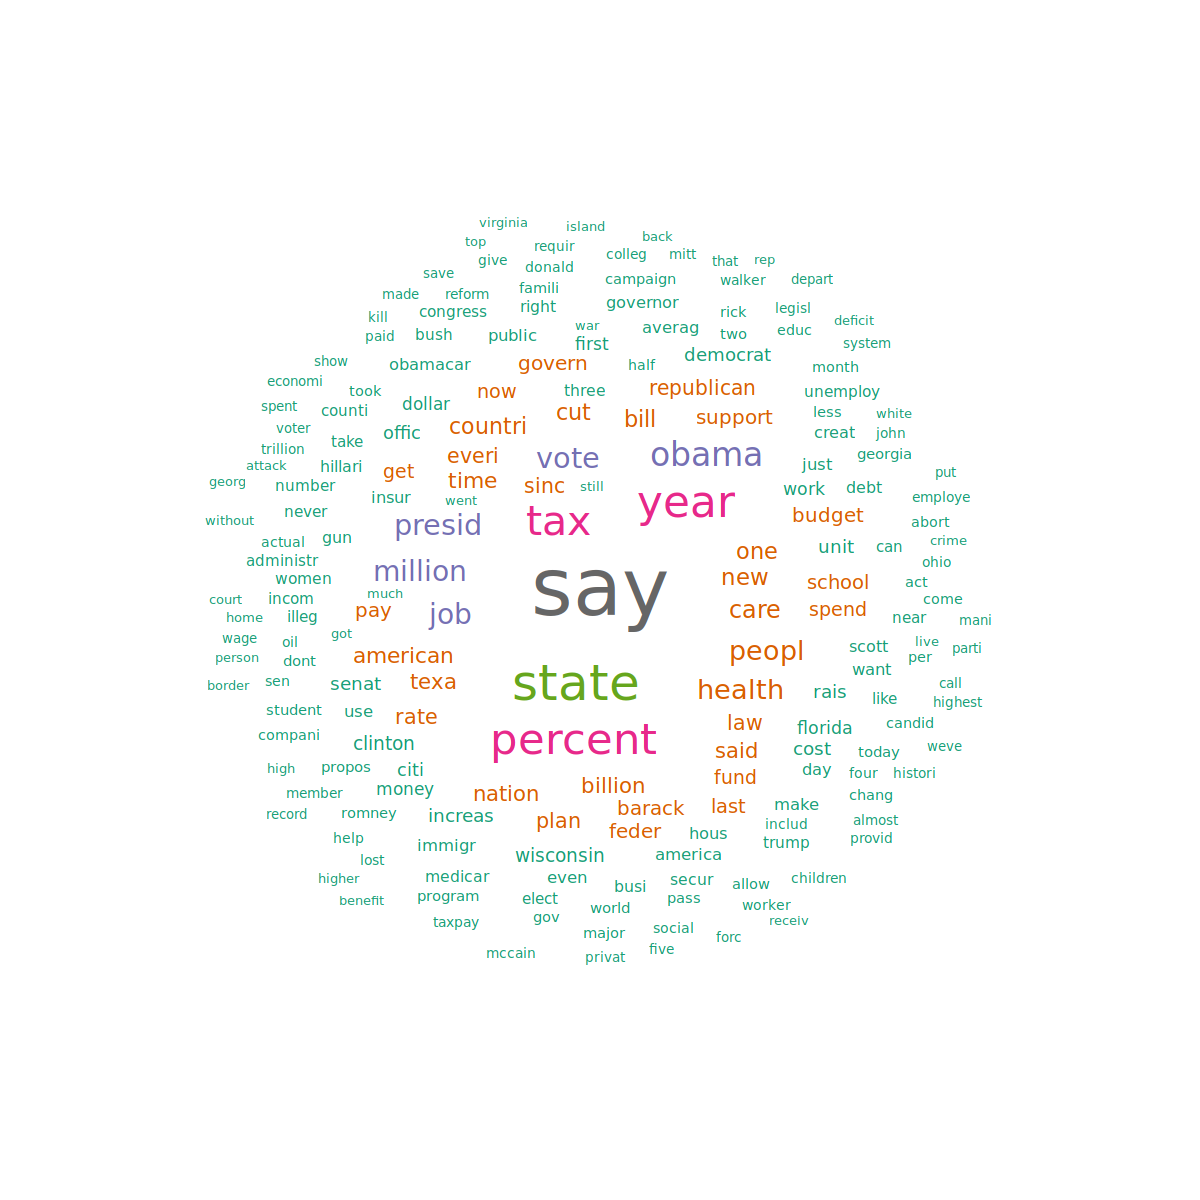

In [15]:
train_termfreq <- termFreq(unlist(df_train$Tokens))


wordcloud(
    words = names(train_termfreq),
    freq = unname(train_termfreq),
    min.freq = 1,
    max.words = 200, 
    random.order = FALSE,
    rot.per = 0.0, # proportion words with 90 degree rotation
    colors = brewer.pal(8, "Dark2")
)

## Feature extraction: Point Mutual Information

PMI measures how much the occurrence of one event (e.g., a word) tells us about the occurrence of another event (e.g., a label). If the PMI is positive, it indicates a positive association or dependency between the events, meaning they tend to co-occur more often than expected by chance. Conversely, if the PMI is negative, it indicates a negative association or dependency, meaning the events tend to occur together less frequently than expected by chance.

We calculate PMI in order to select words that are informative for a specific label:


$$ \text{PMI}(X,Y) = \log_2\bigg(\frac{P_{X,Y}(x,y)}{P_{X}(x) \cdot P_{Y}(y)}\bigg) $$


Where:

- PMI(X,Y) : point mutual information between X and Y.
- p(x, y) : the joint probability of X and Y.
- p(x), p(y) : the marginal probabilities of X and Y, respectively.


In this section we would like to find the PMI for our dataset and select the tokens with PMI > 0.

In [37]:
df_words = data.frame()
#looping for all the labels 
for (j in 0:5){
    #select from the data corresponds to the label and name it new_df
    train_data %>%
        select(Labels, Text) %>%
        filter(Labels == j) -> new_df
    a = length(new_df$Text)
    
    for (i in  1:a){
        #iterate for all the data to get the words per each label 
        words <- data.frame(preprocessing(train_data$Text[i]))
        colnames(words) <- c('normed_tokens')
        words$Labels <- rep.int(j, length(words$normed_tokens))
         df_words <- rbind(df_words, words)
    }
}

#make a new dataframe containing the count of each words in the labels
df_words %>%
  group_by(Labels, normed_tokens) %>%
  summarise(count = n(), .groups = 'drop') %>%
  arrange(Labels, desc(count)) -> df_data

In [38]:
#calculate total number of words
total_words <- sum(df_data$count)

#calculate the total count for each label
label_counts <- aggregate(count ~ Labels, df_data, sum)

#calculate the total count for each word
word_counts <- aggregate(count ~ normed_tokens, df_data, sum)
word_counts$normed_tokens <- as.character(word_counts$normed_tokens)

#make sure normed_tokens in df_data is character before merge
df_data$normed_tokens <- as.character(df_data$normed_tokens)

#merge the counts back into the original dataframe
df_data <- merge(df_data, label_counts, by = "Labels", suffixes = c("", "_label_total"))
df_data <- merge(df_data, word_counts, by = "normed_tokens", suffixes = c("", "_word_total"))

#calculate probabilities
df_data$P_label <- df_data$count_label_total / total_words
df_data$P_word <- df_data$count_word_total / total_words
df_data$P_word_label <- df_data$count / total_words

#calculate pointwise mutual information
df_data$PMI <- log2(df_data$P_word_label / (df_data$P_word * df_data$P_label))

#print the dataframe
head(df_data)

,normed_tokens,Labels,count,count_label_total,count_word_total,P_label,P_word,P_word_label,PMI
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,aarp,4,1,5458,6,0.08453496,9.292961e-05,1.548827e-05,0.97934551
2,aarp,0,1,10119,6,0.15672578,9.292961e-05,1.548827e-05,0.08872308
3,aarp,2,1,13244,6,0.20512662,9.292961e-05,1.548827e-05,-0.29954911
4,aarp,1,1,12402,6,0.19208550,9.292961e-05,1.548827e-05,-0.20478299
5,aarp,5,1,10656,6,0.16504298,9.292961e-05,1.548827e-05,0.01412382
6,aarp,3,1,12686,6,0.19648416,9.292961e-05,1.548827e-05,-0.23744744


In [39]:
# filter based on the PMI value, PMI > 0
filtered_data <- subset(df_data, PMI > 0)
length(filtered_data$normed_tokens)

[1] 10000

In [40]:
features <- list(unique(filtered_data$normed_tokens))

Here we would like to crop all the tokens in the train set that are not in the feature list.

In [41]:
feature_extraction <- function(df, features){
    
    for (j in 1:length(df)){
        
        df_tok = df[j]
        
        for (i in 1:length(df_tok)){
            tokens <- df_tok[i][[1]]
            tokens <- tokens[tokens %in% features[[1]]]
            df_tok[i] <- list(tokens)
            }
        }
    df[j] = df_tok
    
    return(df)
}

In [42]:
df_train$Tokens <- feature_extraction(df_train$Tokens, features)
head(df_train)

Label,Tokens
<dbl>,<list>
1,"say , anni , list , polit , group , support , thirdtrimest, abort , demand"
3,"hillari, clinton, agre , john , mccain , vote , give , georg , bush , benefit, doubt , iran"
1,"health , care , reform , legisl , like , mandat , free , sex , chang , surgeri"
2,"econom , turnaround, start , end , term"
0,"jim , dunnam , live , district, repres , year , now"
2,"person , stage , work , activ , just , last , year , pass , along , russ , feingold, toughest, ethic , reform , sinc , waterg"


In [43]:
df_test$Tokens <- feature_extraction(df_test$Tokens, features)
head(df_test)

Label,Tokens
<dbl>,<list>
2,"declin , coal , start , start , natur , gas , took , start , begin , presid , georg , bush , administr"
5,"chicago , bear , start , quarterback, last , year , total , number , tenur , uw , faculti , fire , last , two , decad"
3,"say , gop , primari , oppon , glenn , grothman , joe , leibham , cast , compromis, vote , cost , million , higher , electr , cost"
1,"mitt , romney , governor , massachusett, didnt , just , slow , rate , growth , govern , actual , cut"
3,"economi , bled , billion , due , govern , shutdown"
0,"rep , ron , kind , wis , fellow , democrat, went , spend , spree , now , credit , card , max"


Then we would like to build a vocabulary containing only words with PMI > 0.

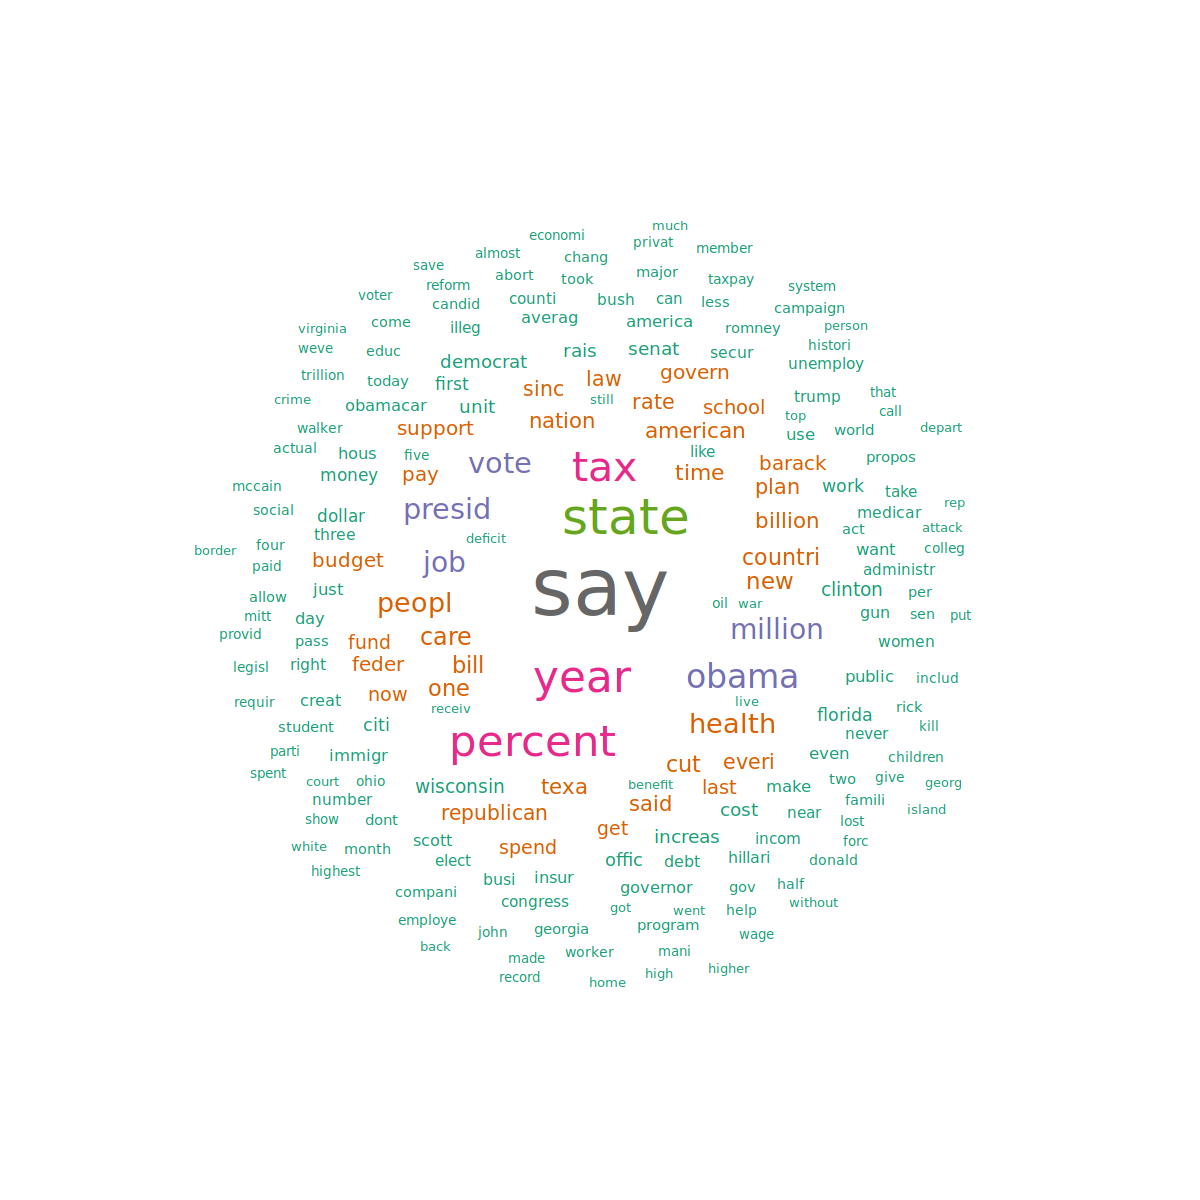

In [44]:
new_vocabulary <- sort(unique(unlist(df_train$Tokens)))

train_termfreq <- termFreq(unlist(df_train$Tokens))


wordcloud(
    words = names(train_termfreq),
    freq = unname(train_termfreq),
    min.freq = 1,
    max.words = 200, 
    random.order = FALSE,
    rot.per = 0.0, # proportion words with 90 degree rotation
    colors = brewer.pal(8, "Dark2")
)

## Multinomial Naive Bayes Classifier

In this work we use Multinomial Naive Bayes classifier in order to predict class of the given news piece.

The definitions here are the following:

- We have set of labels (classes) C, in this case [0, 1, 2, 3, 4, 5]. To each element we refer as c.

- We have each datum (e.g. row in a dataframe), we refer to it as d.


**The goal of the algorithm**: compute P(c|d) and choose class with highest probability.

- To each word in a datum d we refer as t.

- Using marginalization and product rule: $$P(c|d) \propto \prod_k P(t_k|c) P(c) $$

- P(c) is the prior probability of class c.

Probabilities P(t|c):

$$ P(t|c) = \frac{N_{tc} + 1}{\sum_{\tau \in \text{vocabulary}} (N_{\tau c} + 1)}$$.

This is a formula with add-one smoothing: 1 is added so that the probability is never 0.

In [45]:
MNB <- function(labels, train_data, V){
    
    #number of all the datum present in the dataset
    N <- nrow(train_data)
    
    #initialize vectors
    condprob <- matrix(rep(0, length(labels)*length(V)),
                           nrow = length(V), ncol = length(labels))
    prior <- rep(1, length(labels))
    wordcount <- matrix(rep(0, length(labels) * length(V)),
                        nrow = length(V), ncol = length(labels))
    
    for (cc in labels){
        
        df_c <- train_data %>% filter(Label == cc)
        
        #defining prior P(c)
        prior[cc+1] <- nrow(df_c)/N
        
        #making a string of all texts in a class
        text_c <- do.call(c, df_c$Tokens)
        text_c <- text_c[!is.na(unlist(text_c))]
        
        #occurency for each word in a vocabulary
        wordcounts_c <- numeric(length(V))
        
        for(w in seq_along(V)) {
            wordcounts_c[w] <- sum(text_c == V[w])
            }
        
        wordcount[,cc+1] <- wordcounts_c

        #compute conditional probability (with add-one smoothing)
        condprob[,cc+1] <- log((wordcounts_c + 1) / (sum(wordcounts_c + 1)))
        
        }
                              
    result <- NULL
    
    result$cprob <- condprob
    
    result$prior <- prior
    
    rownames(result$cprob) <- V
    colnames(result$cprob) <- labels
    
    
    return(result)
    
}

In [46]:
naive_train <- MNB(0:5, df_train, new_vocabulary)

In [47]:
tail(naive_train$cprob, 20)

,0,1,2,3,4,5
young,-8.642003,-8.029270,-7.620901,-7.924589,-8.696928,-7.531135
younger,-9.047468,-9.127882,-9.923486,-9.177352,-9.390075,-9.728360
your,-7.948856,-7.518444,-7.844045,-8.078740,-8.696928,-7.936601
youth,-9.047468,-9.127882,-8.824874,-8.484205,-9.390075,-9.035213
youthpass,-9.740616,-9.821029,-9.923486,-9.177352,-9.390075,-9.728360
youv,-9.740616,-9.127882,-8.824874,-8.771887,-9.390075,-8.629748
yrs,-9.047468,-9.821029,-9.923486,-9.870499,-9.390075,-9.728360
yuppi,-9.740616,-9.821029,-9.230339,-9.870499,-9.390075,-9.728360
zack,-9.740616,-9.821029,-9.230339,-9.870499,-8.696928,-9.728360
zappala,-9.740616,-9.821029,-9.230339,-9.870499,-9.390075,-9.728360


The upper function calculates conditional probabilities for each word in the vocabulary.

In the function below we firstly select rows from a previous dataframe that correspond to the words that appear in the given datum. Then we find the probabilities P(c|d) and choose the class as the class that has the highest P(c|d).

In [48]:
predict <- function(train, new_vocabulary, bayes){
    
    train$Predicted_label <- numeric(length(train$Tokens)) 
     for (i in 1:length(train$Tokens)){
        sample <- unlist(train$Tokens[i])
        sample <- unique(sample[sample %in% new_vocabulary])
        prob <- apply(bayes$cprob[sample,,drop=F], MARGIN=2, FUN=sum) #sum over columns
        prob <- prob+log(bayes$prior)
        label <- which.max(prob)[[1]]-1
        train$Predicted_label[i] <- label
         }
        
   return(train)     
}

In [49]:
prediction_train <- predict(df_train, new_vocabulary, naive_train)

In [50]:
prediction_test <- predict(df_test, new_vocabulary, naive_train)

## Accuracy evaluation

In [51]:
create_confusion_matrix_plot <- function(data, lv, title) {
  
  #compute the confusion matrix and the accuracy
  conf_mat <- table(data$Predicted_label, data$Label)
  accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
  cat('The accuracy is :', accuracy)

  #turn the confusion matrix into a data frame
  conf_mat_df <- as.data.frame.table(conf_mat)

  #name the columns
  colnames(conf_mat_df) <- c("Predicted_Label", "True_Label", "Count")
  
  #convert to factors with reversed levels
  conf_mat_df$True_Label <- factor(conf_mat_df$True_Label, levels = lv)
  conf_mat_df$Predicted_Label <- factor(conf_mat_df$Predicted_Label, levels = rev(lv))

  #use ggplot2 to create a heatmap
  plot <- ggplot(data = conf_mat_df, aes(x = True_Label, y = Predicted_Label, fill = Count)) +
    geom_tile(aes(fill = Count), colour = "white") +
    scale_fill_gradient(low = "skyblue", high = "darkblue") +
    theme_minimal(base_size=18) + 
    labs(x = "Actual Class", y = "Predicted Class", fill = "Count") +
    geom_text(aes(label = Count), color = "black", size = 10) +
    ggtitle(title)
  
  return(plot)
}

We plot confusion matrix for train set:

The accuracy is : 0.6649409

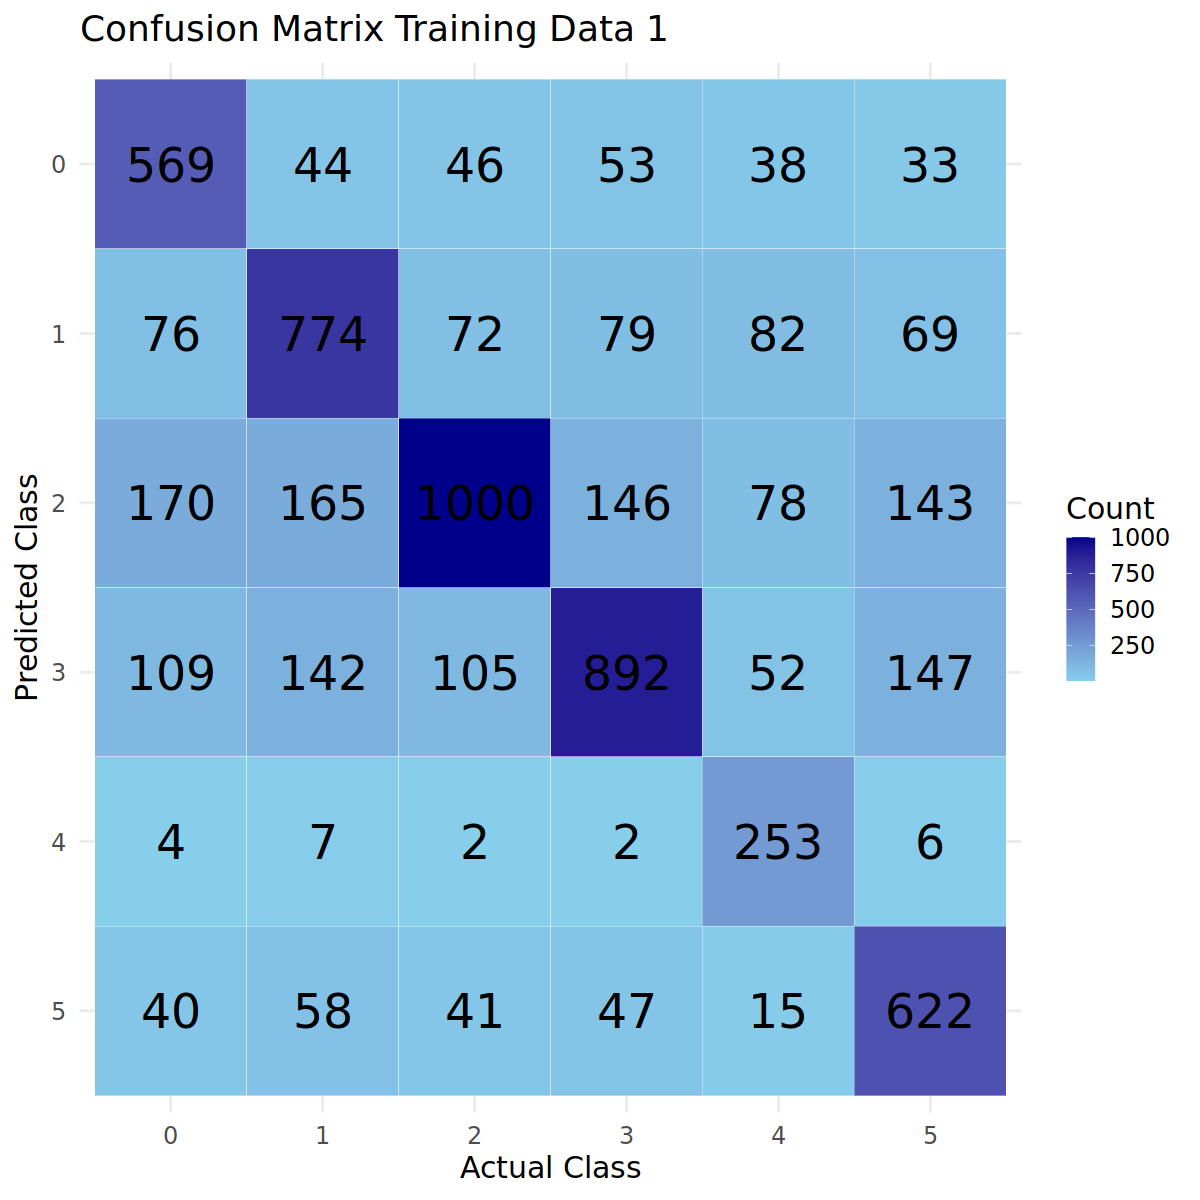

In [52]:
# Calling the confusion matrix plot
create_confusion_matrix_plot(prediction_train, 0:5, "Confusion Matrix Training Data 1")

And then for the test set in order to see the accuarcy on a test set:

The accuracy is : 0.2318305

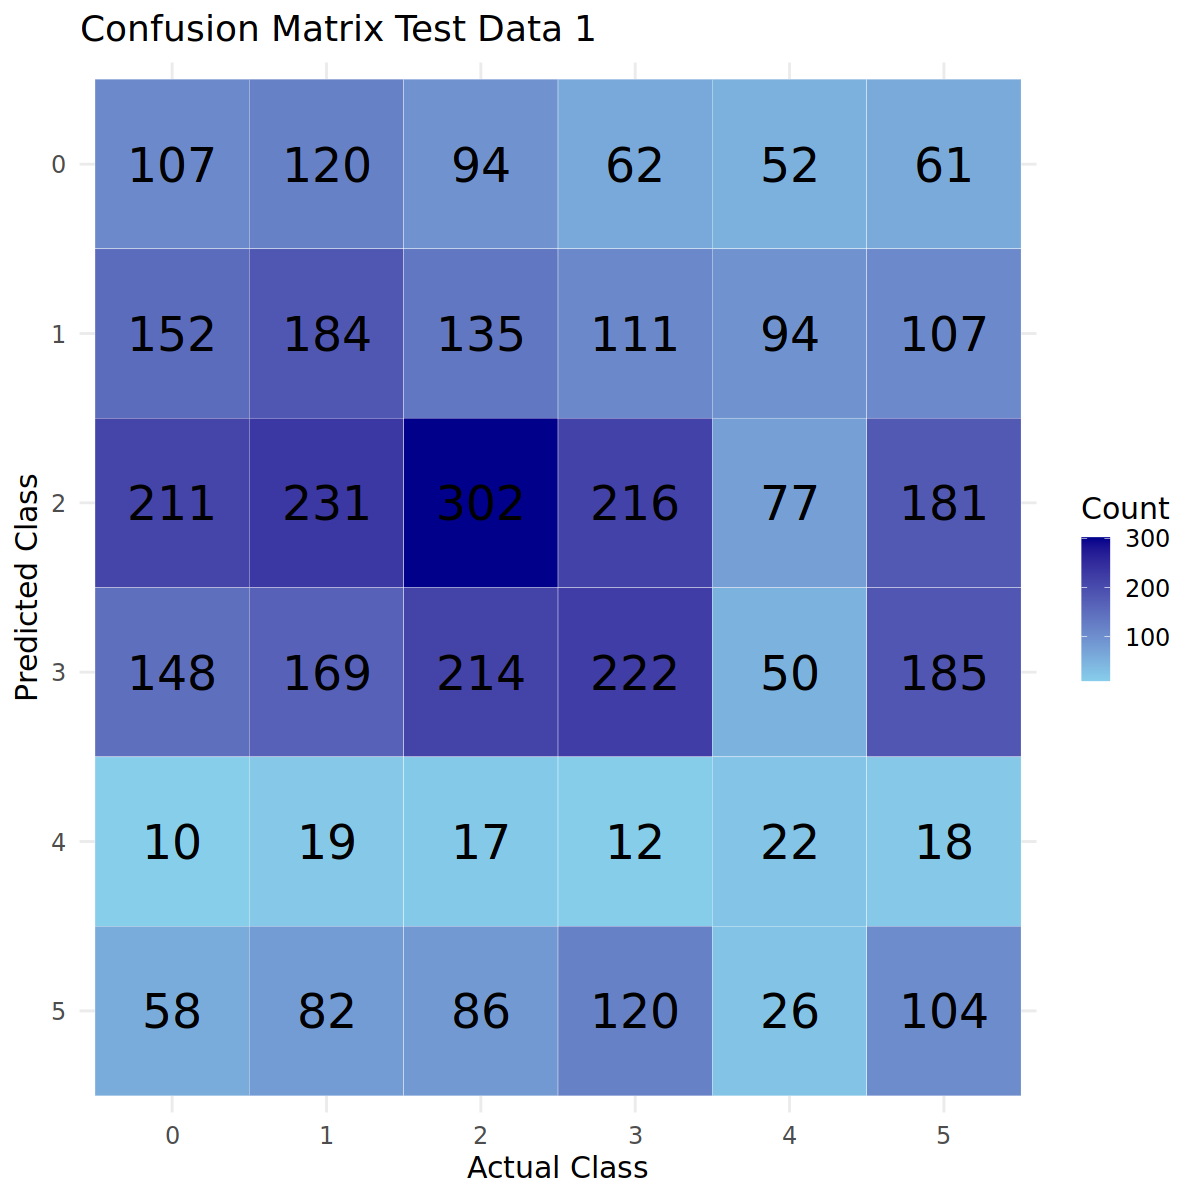

In [73]:
# Calling the confusion matrix plot
create_confusion_matrix_plot(prediction_test, 0:5, "Confusion Matrix Test Data 1")

As we can see, the accuracy is very low. It is just a bit better than a randomizer (0.17).

## Another dataset


We saw that our result is not satisfactory on the previous dataset. We want now to test the developed functions on a new dataset with bigger texts inside.

In [56]:
data_new <-  read_csv('Project/otherdata.csv', show_col_types = FALSE)
head(data_new,2)

data_new <- data_new[1:5000,]

sample <- sample(c(TRUE, FALSE), nrow(data_new), replace=TRUE, prob=c(0.7,0.3))
train_data_new <- data_new[sample, ]
test_data_new <- data_new[!sample, ]

print(dim(train_data_new))
print(dim(test_data_new))

id
1 0 
2 1 
  title                                                                            
1 House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
2 FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart                          
  author         
1 Darrell Lucus  
2 Daniel J. Flynn
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

[1] 3492    5
[1] 1508    5


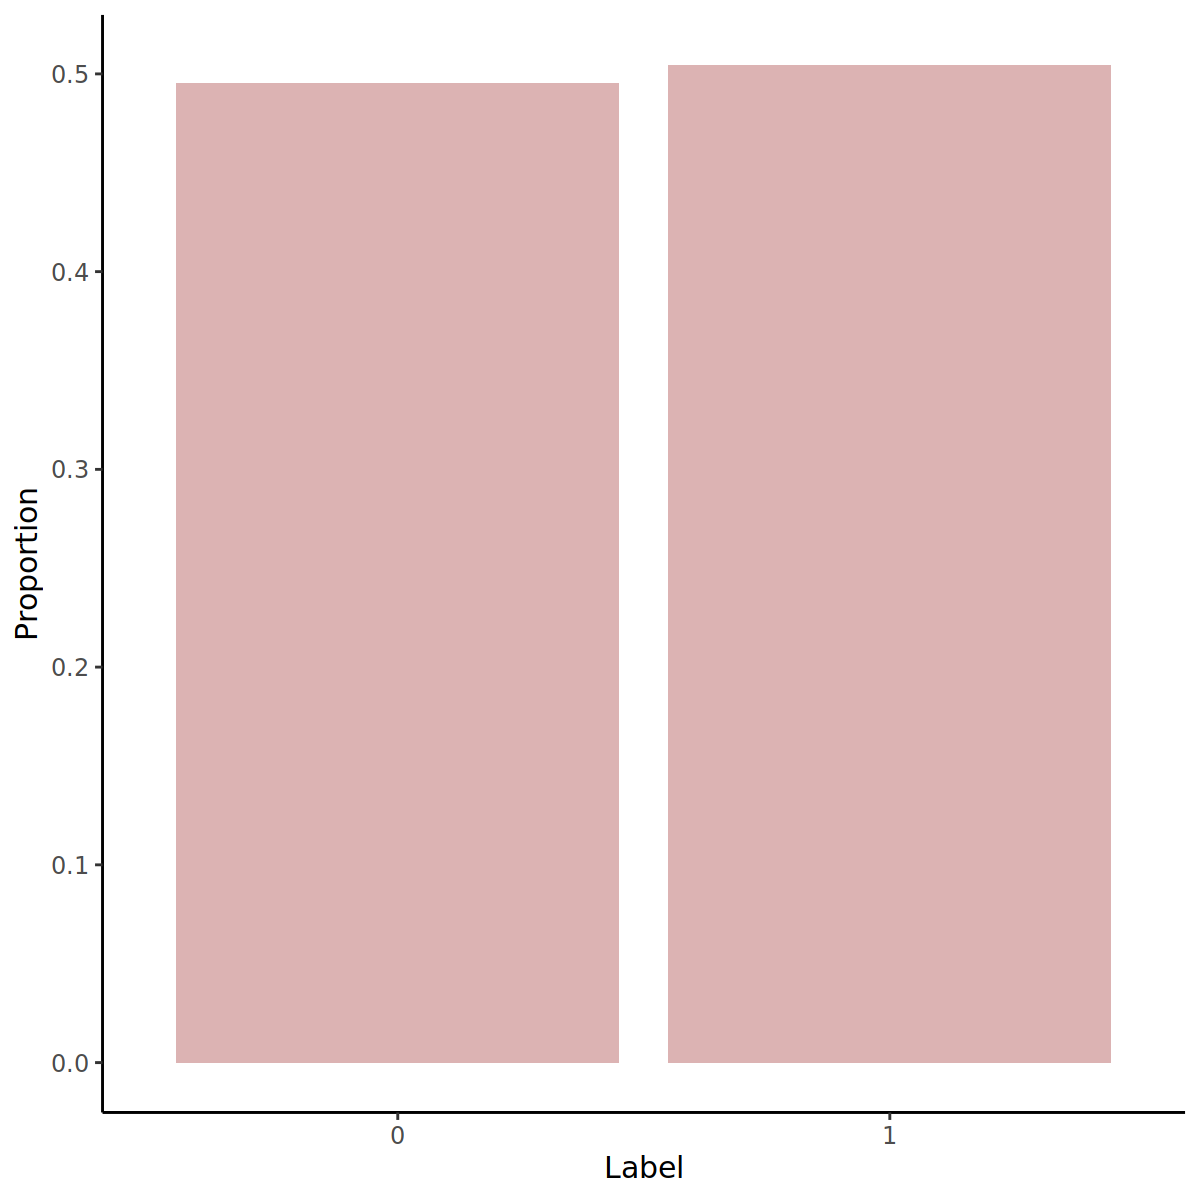

In [57]:
labels <- 0:1

n_occ <- sapply(labels, function(label) sum(train_data_new$label == label))
df <- data.frame(Label = labels, Occurancy = n_occ)

label_proportions <- prop.table(table(train_data_new$label))

df_plot <- data.frame(Label = names(label_proportions),
                      Proportion = label_proportions)

df_plot %>% ggplot(aes(x = Label, y = Proportion.Freq)) +
    geom_bar(stat = "identity", fill = "darkred", alpha=0.3) +
    labs(x = "Label", y = "Proportion") +
    theme_classic(base_size=18) 

Here we follow the same steps as before so we end up with the tokenized entries with words only with PMI > 0.

In [58]:
train_tokens_new <- vectorized_preproc(train_data_new$text)
test_tokens_new <- vectorized_preproc(test_data_new$text)

In [59]:
df_train_new <- data_frame(Label = train_data_new$label, Tokens = train_tokens_new)
df_test_new <- data_frame(Label = test_data_new$label, Tokens = test_tokens_new)

In [60]:
df_words = data.frame()

#iterate for every labels
for (j in 0:1){
    train_data_new %>%
        select(label, text) %>%
        filter(label == j) -> new_df
    a = length(new_df$text)
    #iterate per datum to get the dataframe containing words per each label
    for (i in  1:a){
        words <- data.frame(preprocessing(train_data_new$text[i]))
        colnames(words) <- c('normed_tokens')
        words$Labels <- rep.int(j, length(words$normed_tokens))
        df_words = rbind(df_words, words)
    }
}


df_words %>%
  group_by(Labels, normed_tokens) %>%
  summarise(count = n(), .groups = 'drop') %>%
  arrange(Labels, desc(count)) -> df_data

In [61]:
#calculate total number of words
total_words <- sum(df_data$count)

#calculate the total count for each label
label_counts <- aggregate(count ~ Labels, df_data, sum)

#calculate the total count for each word
word_counts <- aggregate(count ~ normed_tokens, df_data, sum)
word_counts$normed_tokens <- as.character(word_counts$normed_tokens)

#make sure normed_tokens in df_data is character before merge
df_data$normed_tokens <- as.character(df_data$normed_tokens)

#merge the counts back into the original dataframe
df_data <- merge(df_data, label_counts, by = "Labels", suffixes = c("", "_label_total"))
df_data <- merge(df_data, word_counts, by = "normed_tokens", suffixes = c("", "_word_total"))

#calculate probabilities
df_data$P_label <- df_data$count_label_total / total_words
df_data$P_word <- df_data$count_word_total / total_words
df_data$P_word_label <- df_data$count / total_words

#calculate pointwise mutual information
df_data$PMI <- log2(df_data$P_word_label / (df_data$P_word * df_data$P_label))

#print the dataframe
head(df_data)

,normed_tokens,Labels,count,count_label_total,count_word_total,P_label,P_word,P_word_label,PMI
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,a,1,8,753719,16,0.5038643,1.069607e-05,5.348033e-06,-0.01110711
2,a,0,8,742158,16,0.4961357,1.069607e-05,5.348033e-06,0.01119329
3,ª,0,1,742158,2,0.4961357,1.337008e-06,6.685042e-07,0.01119329
4,ª,1,1,753719,2,0.5038643,1.337008e-06,6.685042e-07,-0.01110711
5,à,0,2,742158,4,0.4961357,2.674017e-06,1.337008e-06,0.01119329
6,à,1,2,753719,4,0.5038643,2.674017e-06,1.337008e-06,-0.01110711


In [62]:
filtered_data2 <- subset(df_data, PMI > 0)
length(filtered_data2$normed_tokens)

[1] 36119

In [63]:
features2 <- list(unique(filtered_data2$normed_tokens))

In [64]:
df_train_new$Tokens <- feature_extraction(df_train_new$Tokens, features2)
head(df_train_new,1)

Label
1 1    
  Tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [65]:
df_test_new$Tokens <- feature_extraction(df_test_new$Tokens, features2)
head(df_test_new,1)

Label
1 1    
  Tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

We vizualize here the wordcloud for the new dataset.

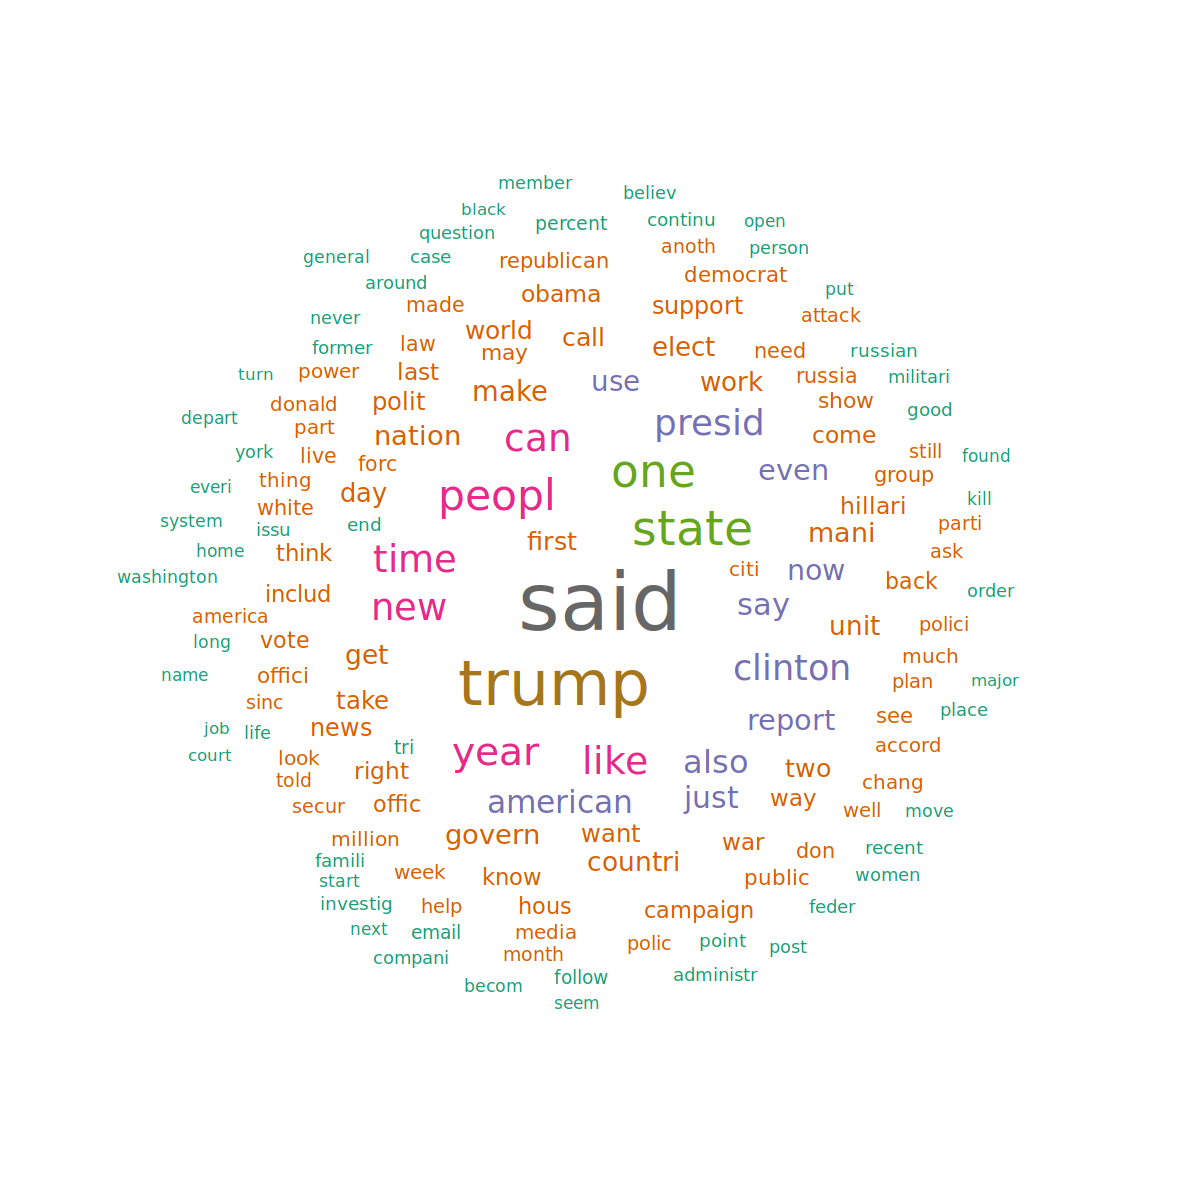

In [66]:
new_vocabulary2 <- sort(unique(unlist(df_train_new$Tokens)))
train_termfreq2 <- termFreq(unlist(df_train_new$Tokens))


wordcloud(
    words = names(train_termfreq2),
    freq = unname(train_termfreq2),
    min.freq = 1,
    max.words = 150, 
    random.order = FALSE,
    rot.per = 0.0, # proportion words with 90 degree rotation
    colors = brewer.pal(8, "Dark2")
)

We arrive to the training on a new dataset and predicting labels.

In [67]:
naive_train_new <- MNB(0:1, df_train_new, new_vocabulary2)

In [68]:
prediction_train_new <- predict(df_train_new, new_vocabulary2, naive_train_new)
prediction_test_new <- predict(df_test_new, new_vocabulary2, naive_train_new)

And finally we can see the accuracy of the algorithm on a new datset.

The accuracy is : 0.957331

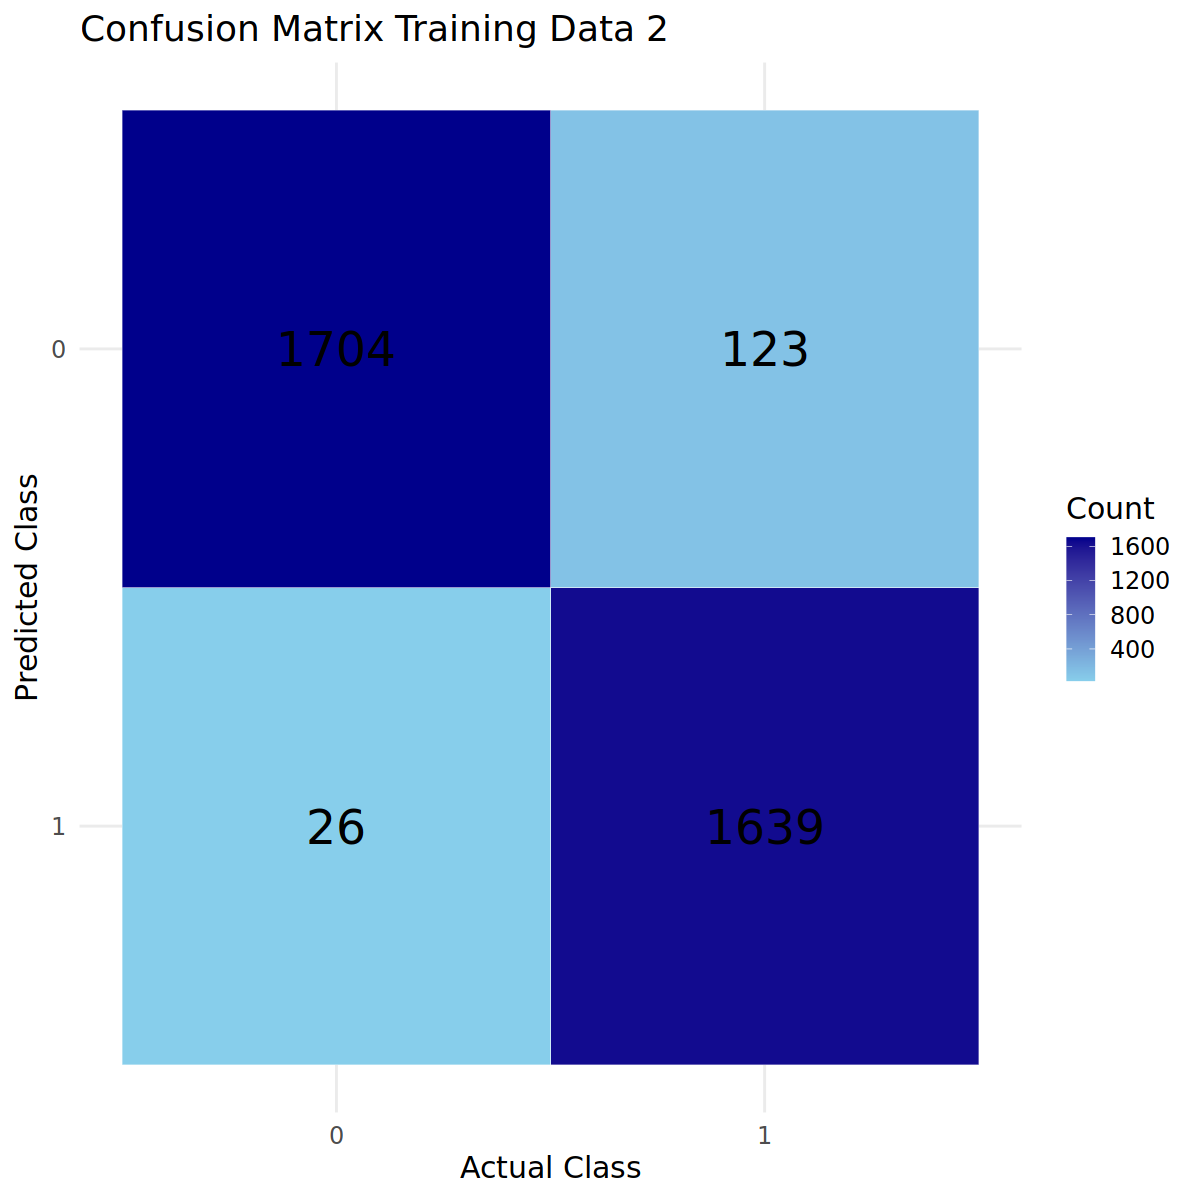

In [69]:
create_confusion_matrix_plot(prediction_train_new, 0:1, "Confusion Matrix Training Data 2")

The accuracy is : 0.8932361

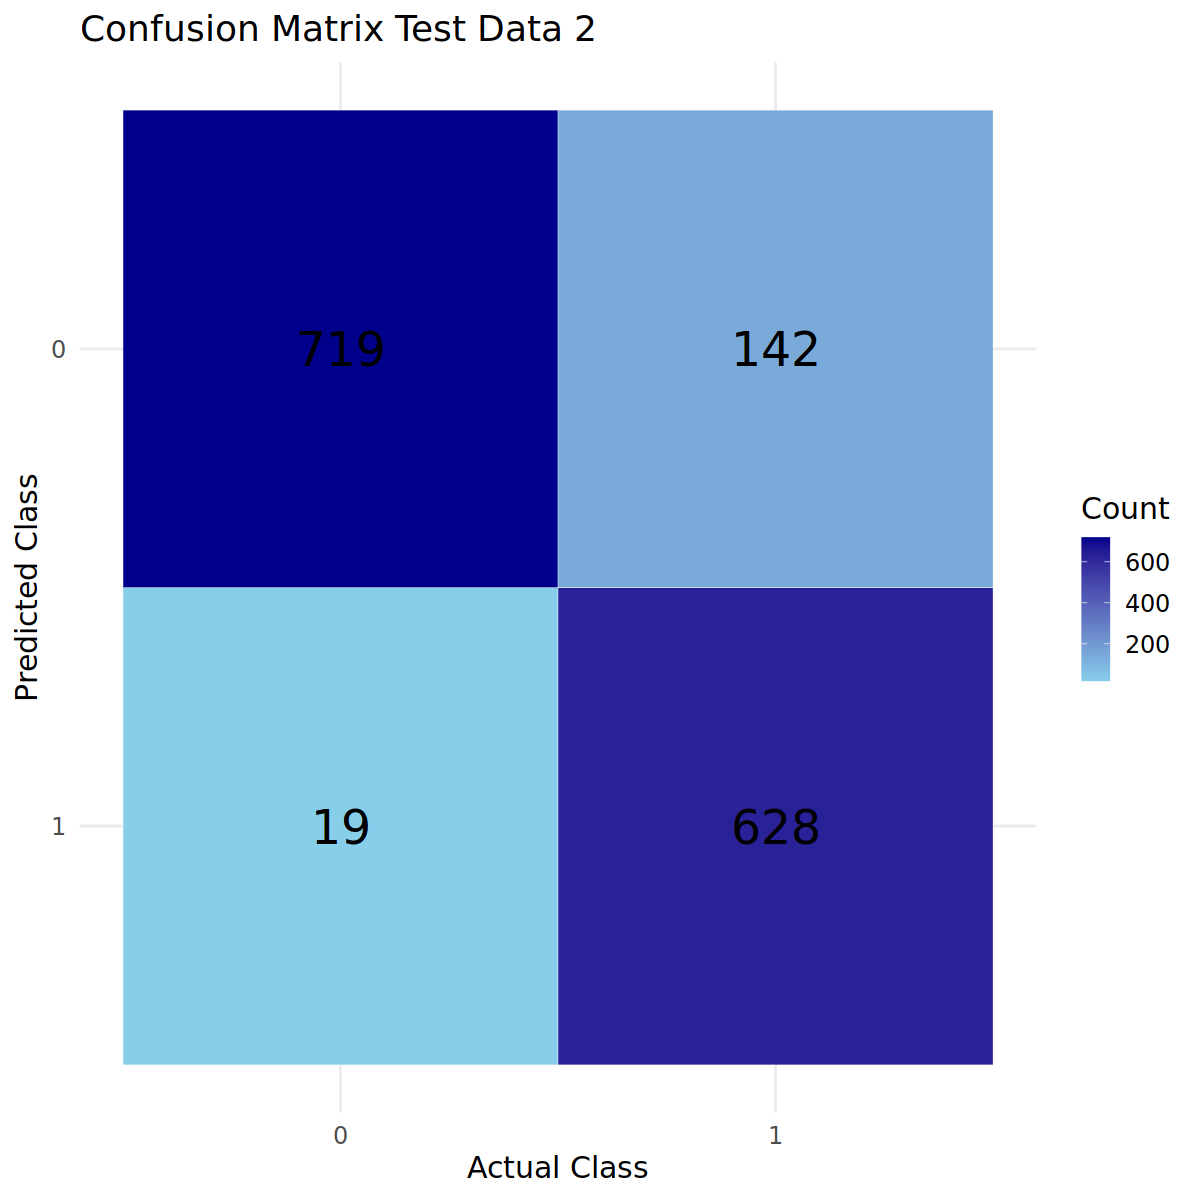

In [70]:
create_confusion_matrix_plot(prediction_test_new, 0:1, "Confusion Matrix Test Data 2")